## 2. Direct Search 

In "1_open_exploration_base_case" the "do nothing policy" was run for 5000 scenarios, with that dataset scenario discovery analysis is executed, in order to define the "worst-case" scenarios. "Worst case" scenarios are these scenarios where the number of the selected KPIs, "Expected Annual Damage" and "Expected Number of Deaths", are performing poorly. 

To find "worst-case" scenarios, the Patient Rule Induction Method (PRIM) is used, which is part of the EMA workbench. PRIM narrows the uncertainty space until it finds boxes where the coverage and the density trade-off is well balanced(Friedman & Fisher 1999).

The result of the scenario discovery done in this notebook is reported and analyzed in section 4.2 of the report. 

### 0. Inporting Libraries

In [1]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Import workbench libraries
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
from ema_workbench import save_results
from ema_workbench import load_results
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

# Import dike model 
from problem_formulation import get_model_for_problem_formulation
from dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1. Loading Data

In [2]:
# Load in the results from the CSV we had saved from running the experiments
results = utilities.load_results('results/5000_scenarios_base_case.csv')
experiments, outcomes = results

# We create a 'combined' dataframe, in which the experiments and outcomes are merged within one pandas dataframe.
df_outcomes = pd.DataFrame(outcomes)
combined = pd.concat([experiments,df_outcomes],axis=1,sort=False)

combined.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\5000_scenarios_base_case.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,82.0,112.588522,10.0,0.060112,207.259283,10.0,0.681905,298.346650,10.0,0.204375,...,0,0.208533,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
1,14.0,51.029922,1.0,0.277459,302.598285,1.5,0.960055,156.916590,10.0,0.004221,...,0,1.197254,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
2,128.0,56.198749,1.5,0.880576,136.816986,10.0,0.344347,221.692894,10.0,0.175895,...,0,0.870198,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
3,96.0,123.505345,1.5,0.797417,322.362756,1.5,0.977793,292.806136,10.0,0.765065,...,0,0.050221,2.064967e+07,0,0.011789,0.0,0,0.0,0.0,0.0
4,52.0,311.328249,10.0,0.433875,130.977495,1.0,0.646960,95.169589,10.0,0.962059,...,0,0.000000,3.580277e+07,0,0.018065,0.0,0,0.0,0.0,0.0


The aggregation is done with the aggregate function 'aggregate_kpi' created in "aggragation_function.py"

In [3]:
# Importing aggragation_function used to aggregate the outcomes into the KPI we want.
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "province" and therefore the KPI is added per province.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
from aggragation_function import aggregate_kpi

# Append the KPIs we would like to analyse.
combined = aggregate_kpi(combined, "Expected Number of Deaths", "total")
combined = aggregate_kpi(combined, "Expected Annual Damage", "total")

In [7]:
combined.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2,Expected Number of Deaths,Expected Annual Damage,Death_bool,Damage_bool
0,82.0,112.588522,10.0,0.060112,207.259283,10.0,0.681905,298.346650,10.0,0.204375,...,0.000000,0.0,0,0.0,0.0,0.0,2.635901,2.318300e+09,False,False
1,14.0,51.029922,1.0,0.277459,302.598285,1.5,0.960055,156.916590,10.0,0.004221,...,0.000000,0.0,0,0.0,0.0,0.0,5.630018,5.614819e+09,True,True
2,128.0,56.198749,1.5,0.880576,136.816986,10.0,0.344347,221.692894,10.0,0.175895,...,0.000000,0.0,0,0.0,0.0,0.0,2.749357,1.419024e+09,True,False
3,96.0,123.505345,1.5,0.797417,322.362756,1.5,0.977793,292.806136,10.0,0.765065,...,0.011789,0.0,0,0.0,0.0,0.0,0.193631,1.757437e+08,False,False
4,52.0,311.328249,10.0,0.433875,130.977495,1.0,0.646960,95.169589,10.0,0.962059,...,0.018065,0.0,0,0.0,0.0,0.0,0.459794,7.197534e+08,False,False


### 2. Analysis and Results

**Undesirable outcomes** 

Undesirable outcomes are defined as being in the 80th percentile, which means that the number of deaths and damages for the searched scenarios are in the upper 20% of their range.  

**Results** 

From the running PRIM method follows that there are 352 scenarios of interest, which is 7% of all 5000 scenarios. These scenarios are predominantly caused by three uncertainties. These are the following uncertainties:


- A.1_pfail between 0 and 0.40
- A.3_pfail between 0 and 0.21
- A.1_Bmax between 30 and 330

[MainProcess/INFO] 5000 points remaining, containing 352 cases of interest
[MainProcess/INFO] mean: 0.8, mass: 0.052, coverage: 0.5909090909090909, density: 0.8 restricted_dimensions: 4


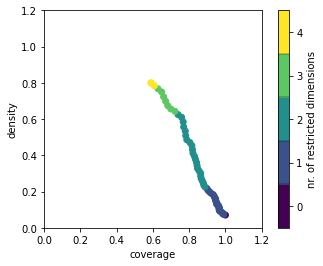

In [4]:
# Select the uncertainty values
cleaned_experiments = combined.iloc[:,:19]

# Calculate the value (threshold) where the upper 20% range starts

percentile_dmg = np.percentile(combined["Expected Annual Damage"], 80)
percentile_deaths = np.percentile(combined["Expected Number of Deaths"], 80)


# Bool the values if they are larger than the threshold

combined["Death_bool"] = combined["Expected Number of Deaths"] > percentile_deaths
combined["Damage_bool"] = combined["Expected Annual Damage"] > percentile_dmg

# If cost and deaths and variance arein the 66th upper percentiles indicate true
y = combined["Death_bool"] & combined["Damage_bool"]

# Execute prim algorithm
prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.6)
box1 = prim_alg.find_box()

# Show trade off plot
box1.show_tradeoff()
plt.savefig("images/PRIM_density_convergence.png")
plt.show()


#### Box selection 
The selection of a proper box with good balance between density and coverage is very important. In the perfext case the coverage should be over 80%, however in this case that means that the density would be around 40%. This is why a box with lower coverage of 72.2% is selected but with density of 64.3%. Moreover, this box contains 3 dimensions instead of 2, which is less limiting. 

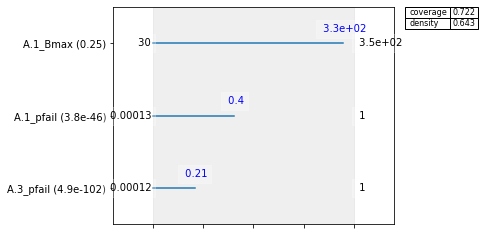

In [5]:
# Choosing the best box and inspecting the corresponding coverage, density and uncertainty ranges.
box1.inspect(49,style='graph')  
box1.select(49)                # box 49 is sellected \
# saving image
plt.savefig("images/PRIM_box.png", bbox_inches= 'tight')
plt.show()


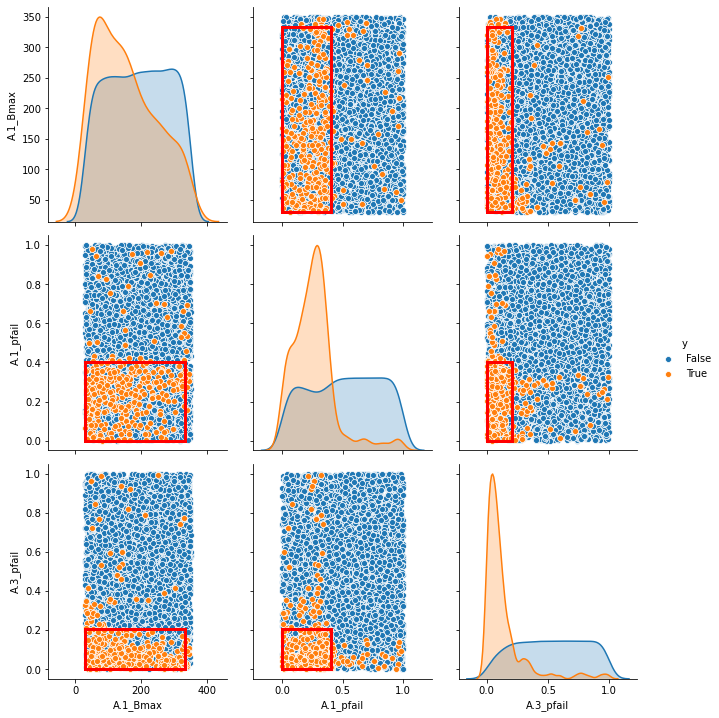

In [6]:
# matrix of scatter plots
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(10,10)
# saving image
plt.savefig("images/PRIM_results_distributionmatrix.png")
plt.show()